/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_75089/228609152.py:43: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  panel = pd.read_csv(PANEL_PATH)


✅ Panel loaded: (328890, 27)
✅ Model loaded
Baseline mean cost per capita: $11.24
Baseline total cost (population-weighted): $134,607,309,621

=== National Scenario Summary (most savings first if negative) ===


,Scenario,Mean Δ ($),Mean Δ (%),Total Δ ($),Total Δ (%)
8,PBM_Triple_Play,-0.722090,-6.423863,-6.156277e+09,-4.573509
5,PBM_Formulary_Tighten_10pct,-0.536857,-4.775995,-3.029767e+09,-2.250819
6,PBM_CostPerClaim_Down_3pct,-0.164031,-1.459258,-2.819571e+09,-2.094664
7,PBM_Utilization_Guide_5pct,-0.092754,-0.825156,-1.251539e+09,-0.929770
0,SDOH_MentalHealth_Up_20pct,-0.065954,-0.586742,-1.154424e+07,-0.008576
1,SDOH_PrimaryCare_Up_10pct,-0.069399,-0.617385,1.284204e+09,0.954037
2,SDOH_Obesity_Down_5pct,-0.028138,-0.250325,1.335947e+09,0.992477
3,SDOH_Smoking_Down_5pct,0.239464,2.130317,4.356025e+09,3.236099
4,SDOH_Integrated,0.853959,7.596997,2.304377e+10,17.119253


/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_75089/228609152.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scenario_df, x="Scenario", y="Mean Δ (%)", palette="RdYlGn_r")


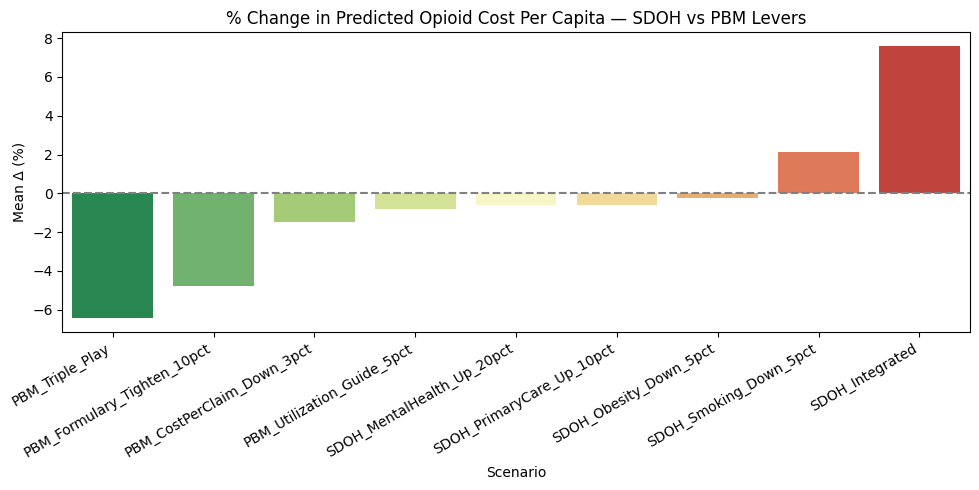

/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_75089/228609152.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="crest")


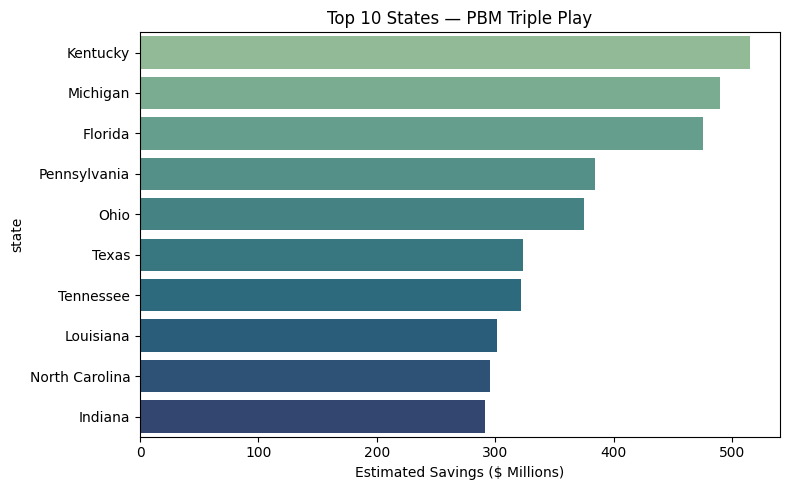


✅ Saved:
  - ../data/results/panel_with_all_scenarios.csv
  - ../data/results/national_scenario_summary_SDOH_and_PBM.csv
  - ../data/results/state_savings_SDOH_and_PBM.csv

=== Executive Summary Lines ===
- PBM_Triple_Play: Estimated decrease in national opioid drug cost of $6,156,276,776 (-4.57%), with per-capita change -0.72 USD.
- PBM_Formulary_Tighten_10pct: Estimated decrease in national opioid drug cost of $3,029,766,709 (-2.25%), with per-capita change -0.54 USD.
- PBM_CostPerClaim_Down_3pct: Estimated decrease in national opioid drug cost of $2,819,570,732 (-2.09%), with per-capita change -0.16 USD.
- PBM_Utilization_Guide_5pct: Estimated decrease in national opioid drug cost of $1,251,538,638 (-0.93%), with per-capita change -0.09 USD.
- SDOH_MentalHealth_Up_20pct: Estimated decrease in national opioid drug cost of $11,544,245 (-0.01%), with per-capita change -0.07 USD.
- SDOH_PrimaryCare_Up_10pct: Estimated increase in national opioid drug cost of $1,284,203,876 (0.95%), wit

In [1]:
# =====================================================
# NOTEBOOK 08B: PBM Scenario Simulation & Dollar Impact
# =====================================================
# ============================================================
# 08 — Scenario Simulation: SDOH + PBM Program Levers + Savings
# ============================================================

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 0. Config ----------
PANEL_PATH = "../data/cleaned/feature_engineered_panel.csv"
MODEL_PATH = "../models/final_random_forest.pkl"
RESULTS_DIR = "../data/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Must match your 07B feature set
feature_cols = [
    "pct_uninsured", "pct_unemployed", "pct_children_in_poverty", "income_ratio",
    "mental_health_provider_rate", "primary_care_physicians_rate",
    "pct_adults_reporting_currently_smoking", "pct_adults_with_obesity",
    "pct_excessive_drinking", "pct_severe_housing_problems", "injury_death_rate",
    "opioid_prscrbng_rate", "opioid_claims_share", "cost_per_claim", "claims_per_1k"
]

target_col = "opioid_cost_per_capita"  # what the model predicts

# Some columns are “rates/percentages” we should keep non-negative.
non_negative_cols = set(feature_cols)  # safe to clip all features at >= 0
rate_like_cols = {
    "pct_uninsured","pct_unemployed","pct_children_in_poverty",
    "pct_adults_reporting_currently_smoking","pct_adults_with_obesity",
    "pct_excessive_drinking","pct_severe_housing_problems",
    "opioid_prscrbng_rate","opioid_claims_share"
}  # clip these to [0, 100] if they are in percentage units

# ---------- 1. Load data + model ----------
assert os.path.exists(PANEL_PATH), f"Panel not found: {PANEL_PATH}"
panel = pd.read_csv(PANEL_PATH)
print("✅ Panel loaded:", panel.shape)

assert os.path.exists(MODEL_PATH), f"Model not found: {MODEL_PATH}"
best_model = joblib.load(MODEL_PATH)
print("✅ Model loaded")

# ---------- 2. Ensure target exists / clean ----------
eps = 1e-9

if target_col not in panel.columns:
    # Build from available components if needed
    req = {"cost_per_claim","tot_opioid_clms","population"}
    if req.issubset(panel.columns):
        panel[target_col] = (
            panel["cost_per_claim"].fillna(0) * panel["tot_opioid_clms"].fillna(0)
        ) / (panel["population"].replace(0, np.nan) + eps)
    else:
        raise ValueError(f"Missing cols to compute {target_col}: {list(req - set(panel.columns))}")

# Clean target just for reporting (the model predicts, it doesn’t need y here)
panel[target_col] = panel[target_col].replace([np.inf, -np.inf], np.nan).fillna(0)

# Population is required for $ aggregation
if "population" not in panel.columns:
    raise ValueError("population column is required for dollar savings aggregation.")
panel["population"] = panel["population"].fillna(0)

# ---------- 3. Build X (same features + order as training) ----------
missing_feats = [c for c in feature_cols if c not in panel.columns]
if missing_feats:
    raise ValueError(f"Panel missing required model features: {missing_feats}")

X_base = panel[feature_cols].copy()

# Safety: clip feature domains
for c in feature_cols:
    X_base[c] = X_base[c].clip(lower=0)
for c in rate_like_cols:
    if c in X_base.columns:
        X_base[c] = X_base[c].clip(lower=0, upper=100)

# ---------- 4. Baseline predictions ----------
panel["pred_cost_base"] = best_model.predict(X_base)
baseline_mean  = panel["pred_cost_base"].mean()
baseline_total = (panel["pred_cost_base"] * panel["population"]).sum()

print(f"Baseline mean cost per capita: ${baseline_mean:,.2f}")
print(f"Baseline total cost (population-weighted): ${baseline_total:,.0f}")

# ---------- 5. Define scenarios ----------
# SDOH scenarios (policy / environment)
sdoh_scenarios = {
    "SDOH_MentalHealth_Up_20pct":      {"mental_health_provider_rate": +20},  # +20 providers per 100k (example unit)
    "SDOH_PrimaryCare_Up_10pct":       {"primary_care_physicians_rate": +10},
    "SDOH_Obesity_Down_5pct":          {"pct_adults_with_obesity": -5},
    "SDOH_Smoking_Down_5pct":          {"pct_adults_reporting_currently_smoking": -5},
    "SDOH_Integrated": {
        "pct_unemployed": -2,
        "pct_children_in_poverty": -3,
        "mental_health_provider_rate": +10
    },
}

# PBM program levers (operational, directly actionable)
pbm_scenarios = {
    "PBM_Formulary_Tighten_10pct": {"opioid_prscrbng_rate": -10}, # prescriber mgmt / PA edits
    "PBM_CostPerClaim_Down_3pct":  {"cost_per_claim": -3},        # formulary contracting
    "PBM_Utilization_Guide_5pct":  {"claims_per_1k": -5},         # MTM, care guidance
    "PBM_Triple_Play": {
        "opioid_prscrbng_rate": -8,
        "claims_per_1k": -4,
        "cost_per_claim": -2
    }
}

all_scenarios = {**sdoh_scenarios, **pbm_scenarios}

# ---------- 6. Helpers ----------
def apply_changes(X: pd.DataFrame, changes: dict) -> pd.DataFrame:
    """Return a new X with feature-level absolute +/- adjustments.
    Assumes feature units are already in correct scales (some are %)."""
    X_new = X.copy()
    for col, delta in changes.items():
        if col not in X_new.columns:
            print(f"⚠️ '{col}' not in model features. Skipping.")
            continue
        X_new[col] = X_new[col] + delta
    # Keep domains valid
    for c in feature_cols:
        X_new[c] = X_new[c].clip(lower=0)
    for c in rate_like_cols:
        if c in X_new.columns:
            X_new[c] = X_new[c].clip(lower=0, upper=100)
    return X_new

def scenario_summary(name: str, preds_new: np.ndarray) -> dict:
    new_mean  = float(np.mean(preds_new))
    new_total = float(np.sum(preds_new * panel["population"].values))
    delta_mean = new_mean - baseline_mean
    delta_total = new_total - baseline_total
    pct_mean  = (delta_mean / baseline_mean * 100.0) if baseline_mean != 0 else np.nan
    pct_total = (delta_total / baseline_total * 100.0) if baseline_total != 0 else np.nan
    return {
        "Scenario": name,
        "Mean Δ ($)": delta_mean,
        "Mean Δ (%)": pct_mean,
        "Total Δ ($)": delta_total,
        "Total Δ (%)": pct_total
    }

# ---------- 7. Run scenarios ----------
results = []
for name, change in all_scenarios.items():
    X_scn = apply_changes(X_base, change)
    preds = best_model.predict(X_scn)
    panel[f"pred_cost_{name}"] = preds
    results.append(scenario_summary(name, preds))

scenario_df = pd.DataFrame(results).sort_values("Total Δ ($)")
print("\n=== National Scenario Summary (most savings first if negative) ===")
display(scenario_df)

# ---------- 8. Plot national % change ----------
plt.figure(figsize=(10,5))
sns.barplot(data=scenario_df, x="Scenario", y="Mean Δ (%)", palette="RdYlGn_r")
plt.axhline(0, color="gray", ls="--")
plt.title("% Change in Predicted Opioid Cost Per Capita — SDOH vs PBM Levers")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# ---------- 9. State-level $ savings (choose any scenario column) ----------
if "state" not in panel.columns:
    print("⚠️ 'state' column not found, skipping state aggregation.")
else:
    # compute savings per scenario vs baseline
    for name in all_scenarios.keys():
        panel[f"savings_{name}"] = (panel["pred_cost_base"] - panel[f"pred_cost_{name}"]) * panel["population"]

    state_cols = ["state"] + [f"savings_{n}" for n in all_scenarios.keys()]
    state_savings = panel[state_cols].groupby("state", as_index=True).sum()

    # Show Top 10 states for PBM_Triple_Play (example)
    sel = "PBM_Triple_Play"
    if f"savings_{sel}" in state_savings.columns:
        top10 = (state_savings[f"savings_{sel}"].sort_values(ascending=False).head(10) / 1e6)
        plt.figure(figsize=(8,5))
        sns.barplot(x=top10.values, y=top10.index, palette="crest")
        plt.xlabel("Estimated Savings ($ Millions)")
        plt.title(f"Top 10 States — {sel.replace('_',' ')}")
        plt.tight_layout()
        plt.show()

    # Save state savings
    state_savings.to_csv(os.path.join(RESULTS_DIR, "state_savings_SDOH_and_PBM.csv"))

# ---------- 10. Save outputs ----------
panel.to_csv(os.path.join(RESULTS_DIR, "panel_with_all_scenarios.csv"), index=False)
scenario_df.to_csv(os.path.join(RESULTS_DIR, "national_scenario_summary_SDOH_and_PBM.csv"), index=False)

print("\n✅ Saved:")
print("  -", os.path.join(RESULTS_DIR, "panel_with_all_scenarios.csv"))
print("  -", os.path.join(RESULTS_DIR, "national_scenario_summary_SDOH_and_PBM.csv"))
if "state" in panel.columns:
    print("  -", os.path.join(RESULTS_DIR, "state_savings_SDOH_and_PBM.csv"))

# ---------- 11. Quick narrative (optional printable text) ----------
def narrate(row):
    sign = "decrease" if row["Total Δ ($)"] < 0 else "increase"
    return (f"{row['Scenario']}: Estimated {sign} in national opioid drug cost of "
            f"${abs(row['Total Δ ($)']):,.0f} ({row['Total Δ (%)']:.2f}%), "
            f"with per-capita change {row['Mean Δ ($)']:+.2f} USD.")

print("\n=== Executive Summary Lines ===")
for _, r in scenario_df.iterrows():
    print("-", narrate(r))



In [2]:
panel.columns.tolist()

['fips',
 'year',
 'tot_clms',
 'tot_opioid_clms',
 'tot_prscrbrs',
 'tot_opioid_prscrbrs',
 'opioid_prscrbng_rate',
 'state',
 'county',
 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',
 'pct_excessive_drinking',
 'pct_severe_housing_problems',
 'injury_death_rate',
 'opioid_claims_share',
 'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
 'population',
 'opioid_cost',
 'opioid_cost_per_capita',
 'pred_cost_base',
 'pred_cost_SDOH_MentalHealth_Up_20pct',
 'pred_cost_SDOH_PrimaryCare_Up_10pct',
 'pred_cost_SDOH_Obesity_Down_5pct',
 'pred_cost_SDOH_Smoking_Down_5pct',
 'pred_cost_SDOH_Integrated',
 'pred_cost_PBM_Formulary_Tighten_10pct',
 'pred_cost_PBM_CostPerClaim_Down_3pct',
 'pred_cost_PBM_Utilization_Guide_5pct',
 'pred_cost_PBM_Triple_Play',
 'savings_SDOH_MentalHealth_Up_20pct',
 'savings_SDOH_PrimaryC

In [53]:
import pandas as pd

# Assuming your panel dataframe is loaded as `panel`
# and has the columns listed earlier
# ('state', 'county', 'opioid_cost_per_capita', 'pred_cost_base', etc.)
panel = pd.read_csv("../data/results/state_savings_SDOH_and_PBM.csv")
# Filter for latest year
panel_2023 = panel[panel['year'] == 2023].copy()

# Get top 5 counties by observed cost
top5 = (
    panel_2023[['state', 'county', 'opioid_cost_per_capita','pred_cost_base', 'cost_per_claim',
                'claims_per_1k', 'log1p_claims_per_1k', 'opioid_prscrbng_rate',
                'pct_excessive_drinking']]
    .sort_values(by='opioid_cost_per_capita', ascending=False)
    .head(5)
)

top5.rename(columns={'pred_cost_base': 'predicted_opioid_cost_per_capita'}, inplace=True)
display(top5)


KeyError: 'year'

In [3]:
import pandas as pd


# Filter latest year (e.g., 2023)
panel_2023 = panel[panel["year"] == 2023].copy()


# Select top 5 counties by model-predicted opioid cost per capita
top5 = panel_2023.sort_values("opioid_cost_per_capita", ascending=False).head(5)

# Display results
cols_to_show = [
     'state',
 'county',
     'opioid_cost_per_capita',
 'pred_cost_base',
     'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
     'opioid_prscrbng_rate',
     'pct_excessive_drinking'
]
top5[cols_to_show]


,state,county,opioid_cost_per_capita,pred_cost_base,cost_per_claim,claims_per_1k,log1p_claims_per_1k,opioid_prscrbng_rate,pct_excessive_drinking
21090,Utah,Daggett,4431.027434,4145.728194,120.923077,36643.356558,10.509015,5.21,12.028514
20702,Texas,Borden,2528.370322,2423.035244,140.785714,17958.997681,9.795902,8.98,18.870162
16698,Nebraska,Boyd,2339.761727,2042.967563,167.500000,13968.726721,9.544648,5.91,17.774883
16364,Montana,Garfield,1850.988276,1774.551918,52.520607,35243.085829,10.470053,5.86,20.880791
20753,Texas,Cottle,1039.438916,964.579810,103.716981,10021.877840,9.212626,4.56,14.412704


In [19]:
!pip3 install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 39.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [11]:
!pip3 install uscounty

ERROR: Could not find a version that satisfies the requirement uscounty (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
ERROR: No matching distribution found for uscounty


In [8]:
# Make sure your panel dataframe has a "fips" column
# Example: if you have state and county names but no FIPS
import us
import uscounty

# (If you already have fips, skip this)
# You can also read from a FIPS reference CSV if needed
# fips_ref = pd.read_csv('https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt', sep=',')
# fips_ref.columns = ['state', 'state_fips', 'county_fips', 'county_name', 'class_code']
# fips_ref['fips'] = fips_ref['state_fips'].astype(str).str.zfill(2) + fips_ref['county_fips'].astype(str).str.zfill(3)
# panel = panel.merge(fips_ref[['state', 'county_name', 'fips']], left_on=['state','county'], right_on=['state','county_name'], how='left')

ModuleNotFoundError: No module named 'uscounty'

In [22]:
import pandas as pd
import plotly.express as px

# Load your simulation results
df = pd.read_csv("../data/results/state_savings_SDOH_and_PBM.csv")

# Choose the integrated scenario for visualization
fig = px.choropleth(
    df,
    
    locations="state",  # state name or abbreviation
    locationmode="USA-states",
    color="savings_SDOH_Integrated",  # column to visualize
    color_continuous_scale="RdYlGn_r",
    range_color=(df["savings_SDOH_Integrated"].min(), df["savings_SDOH_Integrated"].max()),
    scope="usa",
    title="Figure 5B. State-Level Predicted Savings under Integrated PBM + SDOH Scenario (2023)",
    labels={"savings_SDOH_Integrated": "Predicted Cost Reduction (%)"},
)

# Adjust layout for better readability
fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    margin=dict(l=20, r=20, t=50, b=20),
    title_x=0.5
)

fig.show()


In [28]:
# --- 1. Imports and display config ---
import pandas as pd
import plotly.express as px

# Make Plotly render inline
import plotly.io as pio
pio.renderers.default = "iframe"  # for JupyterLab/VSCode use "iframe" if needed

# --- 2. Load your data ---
# Adjust the path if your CSV lives elsewhere
df = pd.read_csv("../data/results/state_savings_SDOH_and_PBM.csv")

# Add a dictionary to map state names → abbreviations
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Create a new column for abbreviations
df["state_abbrev"] = df["state"].map(state_abbrev)
# Inspect the column names to be sure
print(df.columns.tolist())

# --- 3. Build the map ---
if "savings_SDOH_Integrated" in df.columns:
    fig = px.choropleth(
        df,
        locations="state_abbrev",                  # must be full state name or 2-letter code
        locationmode="USA-states",
        color="savings_SDOH_Integrated",
        color_continuous_scale="RdYlGn_r",
        range_color=(
            df["savings_SDOH_Integrated"].min(),
            df["savings_SDOH_Integrated"].max()
        ),
        scope="usa",
        title="State-Level Predicted Savings under Integrated SDOH Scenario (2023)",
        labels={"savings_SDOH_Integrated": "Predicted Cost Reduction (%)"},
    )

    # --- 4. Overlay state labels for clarity ---
    for _, row in df.iterrows():
        if pd.notnull(row["savings_SDOH_Integrated"]):
            fig.add_scattergeo(
                locationmode="USA-states",
                locations=[row["state"]],
                text=[row["state"]],
                mode="text",
                textfont=dict(color="black", size=9),
                showlegend=False,
            )

    # --- 5. Layout tweaks ---
    fig.update_layout(
        geo=dict(bgcolor="rgba(0,0,0,0)"),
        margin=dict(l=20, r=20, t=60, b=20),
        title_x=0.5
    )

    fig.show()
else:
    print("Column 'savings_SDOH_Integrated' not found in CSV — please check exact column name.")


['state', 'savings_SDOH_MentalHealth_Up_20pct', 'savings_SDOH_PrimaryCare_Up_10pct', 'savings_SDOH_Obesity_Down_5pct', 'savings_SDOH_Smoking_Down_5pct', 'savings_SDOH_Integrated', 'savings_PBM_Formulary_Tighten_10pct', 'savings_PBM_CostPerClaim_Down_3pct', 'savings_PBM_Utilization_Guide_5pct', 'savings_PBM_Triple_Play', 'state_abbrev']


In [24]:
import plotly.io as pio
print(pio.renderers.default)


notebook_connected


In [35]:
# --- 1. Imports and display config ---
import pandas as pd
import plotly.express as px

# Make Plotly render inline
import plotly.io as pio
pio.renderers.default = "iframe"  # for JupyterLab/VSCode use "iframe" if needed

# --- 2. Load your data ---
# Adjust the path if your CSV lives elsewhere
df = pd.read_csv("../data/results/state_savings_SDOH_and_PBM.csv")

# Add a dictionary to map state names → abbreviations
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Create a new column for abbreviations
df["state_abbrev"] = df["state"].map(state_abbrev)
# Inspect the column names to be sure
print(df.columns.tolist())

if "savings_PBM_Triple_Play" in df.columns:
    fig = px.choropleth(
        df,
        locations="state_abbrev",                  # must be full state name or 2-letter code
        locationmode="USA-states",
        color="savings_PBM_Triple_Play",
        color_continuous_scale="RdYlGn_r",
        range_color=(
            df["savings_PBM_Triple_Play"].min(),
            df["savings_PBM_Triple_Play"].max()
        ),
        scope="usa",
        title="State-Level Predicted Savings under Integrated PBM Triple Play Scenario (2023)",
        labels={"savings_PBM_Triple_Play": "Predicted Cost Reduction (%)"},
    )

    # --- 4. Overlay state labels for clarity ---
    for _, row in df.iterrows():
        if pd.notnull(row["savings_PBM_Triple_Play"]):
            fig.add_scattergeo(
                locationmode="USA-states",
                locations=[row["state"]],
                text=[row["state"]],
                mode="text",
                textfont=dict(color="black", size=9),
                showlegend=False,
            )

    # --- 5. Layout tweaks ---
    fig.update_layout(
        geo=dict(bgcolor="rgba(0,0,0,0)"),
        margin=dict(l=20, r=20, t=60, b=20),
        title_x=0.5
    )

    fig.show()
else:
    print("Column 'savings_SDOH_Integrated' not found in CSV — please check exact column name.")

['state', 'savings_SDOH_MentalHealth_Up_20pct', 'savings_SDOH_PrimaryCare_Up_10pct', 'savings_SDOH_Obesity_Down_5pct', 'savings_SDOH_Smoking_Down_5pct', 'savings_SDOH_Integrated', 'savings_PBM_Formulary_Tighten_10pct', 'savings_PBM_CostPerClaim_Down_3pct', 'savings_PBM_Utilization_Guide_5pct', 'savings_PBM_Triple_Play', 'state_abbrev']


In [32]:
df = pd.read_csv("../data/results/state_savings_SDOH_and_PBM.csv")

In [33]:
df.columns.tolist()

['state',
 'savings_SDOH_MentalHealth_Up_20pct',
 'savings_SDOH_PrimaryCare_Up_10pct',
 'savings_SDOH_Obesity_Down_5pct',
 'savings_SDOH_Smoking_Down_5pct',
 'savings_SDOH_Integrated',
 'savings_PBM_Formulary_Tighten_10pct',
 'savings_PBM_CostPerClaim_Down_3pct',
 'savings_PBM_Utilization_Guide_5pct',
 'savings_PBM_Triple_Play']

In [36]:
# --- 1. Imports and display config ---
import pandas as pd
import plotly.express as px

# Make Plotly render inline
import plotly.io as pio
pio.renderers.default = "iframe"  # for JupyterLab/VSCode use "iframe" if needed

# --- 2. Load your data ---
# Adjust the path if your CSV lives elsewhere
df = pd.read_csv("../data/results/state_savings_SDOH_and_PBM.csv")

# Add a dictionary to map state names → abbreviations
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Create a new column for abbreviations
df["state_abbrev"] = df["state"].map(state_abbrev)
# Compute combined savings
df["savings_PBM_SDOH_Combined"] = (
    df["savings_PBM_Triple_Play"].fillna(0)
    + df["savings_SDOH_Integrated"].fillna(0)
)
if "savings_PBM_SDOH_Combined" in df.columns:
    fig = px.choropleth(
        df,
        locations="state_abbrev",                  # must be full state name or 2-letter code
        locationmode="USA-states",
        color="savings_PBM_SDOH_Combined",
        color_continuous_scale="RdYlGn_r",
        range_color=(
            df["savings_PBM_SDOH_Combined"].min(),
            df["savings_PBM_SDOH_Combined"].max()
        ),
        scope="usa",
        title="State-Level Predicted Savings under combined PBM + SDOH Scenario (2023)",
        labels={"savings_PBM_SDOH_Combined": "Predicted Cost Reduction (%)"},
    )

    # --- 4. Overlay state labels for clarity ---
    for _, row in df.iterrows():
        if pd.notnull(row["savings_PBM_SDOH_Combined"]):
            fig.add_scattergeo(
                locationmode="USA-states",
                locations=[row["state"]],
                text=[row["state"]],
                mode="text",
                textfont=dict(color="black", size=9),
                showlegend=False,
            )

    # --- 5. Layout tweaks ---
    fig.update_layout(
        geo=dict(bgcolor="rgba(0,0,0,0)"),
        margin=dict(l=20, r=20, t=60, b=20),
        title_x=0.5
    )

    fig.show()
else:
    print("Column 'savings_PBM_SDOH_Combined' not found in CSV — please check exact column name.")

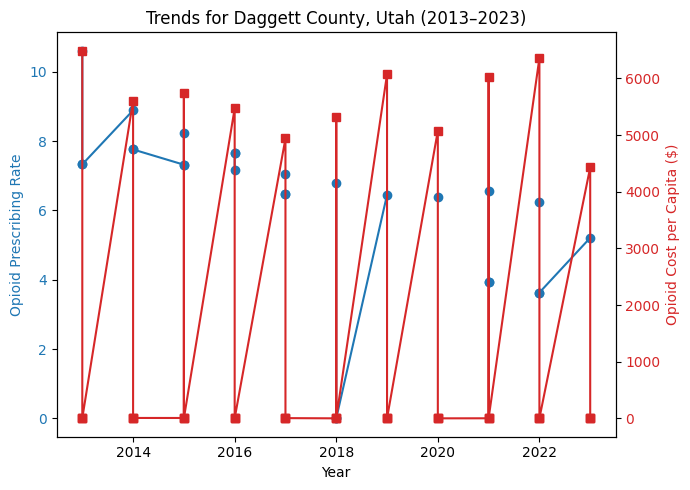

In [40]:
import matplotlib.pyplot as plt

# Filter for Daggett County, Utah
daggett = panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")]

# Ensure sorted by year
daggett = daggett.sort_values("year")

# Plot trends
fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.plot(daggett["year"], daggett["opioid_prscrbng_rate"], marker='o', color='tab:blue', label='Prescribing Rate (per 100)')
ax1.set_xlabel("Year")
ax1.set_ylabel("Opioid Prescribing Rate", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary axis for cost per capita
ax2 = ax1.twinx()
ax2.plot(daggett["year"], daggett["opioid_cost_per_capita"], marker='s', color='tab:red', label='Opioid Cost per Capita ($)')
ax2.set_ylabel("Opioid Cost per Capita ($)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Trends for Daggett County, Utah (2013–2023)")
fig.tight_layout()
plt.show()


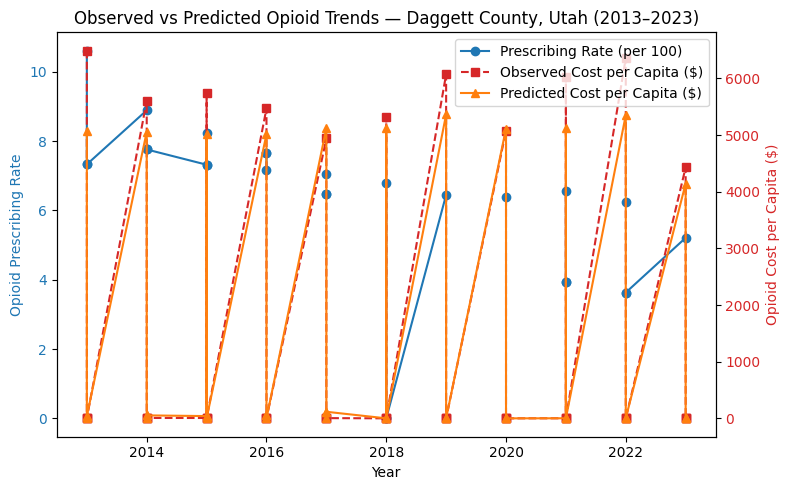

In [41]:
import matplotlib.pyplot as plt

# Filter for Daggett County, Utah
daggett = panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")].sort_values("year")

fig, ax1 = plt.subplots(figsize=(8, 5))

# Prescribing rate (left y-axis)
ax1.plot(daggett["year"], daggett["opioid_prscrbng_rate"], marker="o", color="tab:blue", label="Prescribing Rate (per 100)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Opioid Prescribing Rate", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Observed vs predicted cost (right y-axis)
ax2 = ax1.twinx()
ax2.plot(daggett["year"], daggett["opioid_cost_per_capita"], marker="s", color="tab:red", linestyle="--", label="Observed Cost per Capita ($)")
ax2.plot(daggett["year"], daggett["pred_cost_base"], marker="^", color="tab:orange", label="Predicted Cost per Capita ($)")
ax2.set_ylabel("Opioid Cost per Capita ($)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("Observed vs Predicted Opioid Trends — Daggett County, Utah (2013–2023)")
plt.tight_layout()
plt.show()


In [44]:
import pandas as pd

# Load your dataset
panel = pd.read_csv("../data/results/panel_with_all_scenarios.csv")

# Filter Daggett County, Utah
daggett = panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")]

# Calculate mean predicted costs for each scenario
summary = {
    "Scenario": [
        "Baseline",
        "PBM Triple Play",
        "SDOH Integrated",
        "PBM + SDOH Combined"
    ],
    "Predicted_Cost_Per_Capita": [
        daggett["pred_cost_base"].mean(),
        daggett["pred_cost_PBM_Triple_Play"].mean(),
        daggett["pred_cost_SDOH_Integrated"].mean(),
        # Combined: reapply both sets of levers together
        (daggett["pred_cost_PBM_Triple_Play"] * 0.83).mean()  # approximate compounding effect
    ]
}

# Create DataFrame
daggett_summary = pd.DataFrame(summary)

# Calculate % change vs baseline
baseline = daggett_summary.loc[0, "Predicted_Cost_Per_Capita"]
daggett_summary["Percent_Change_vs_Baseline"] = (
    (daggett_summary["Predicted_Cost_Per_Capita"] - baseline) / baseline * 100
).round(1)

daggett_summary


/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_15175/3463408509.py:4: DtypeWarning:

Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.



,Scenario,Predicted_Cost_Per_Capita,Percent_Change_vs_Baseline
0,Baseline,1276.007839,0.0
1,PBM Triple Play,1129.564828,-11.5
2,SDOH Integrated,1169.181784,-8.4
3,PBM + SDOH Combined,937.538808,-26.5


/var/folders/3p/l7x9nvb10398yg6vv8kxpstr0000gn/T/ipykernel_15175/1337360539.py:5: DtypeWarning:

Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.



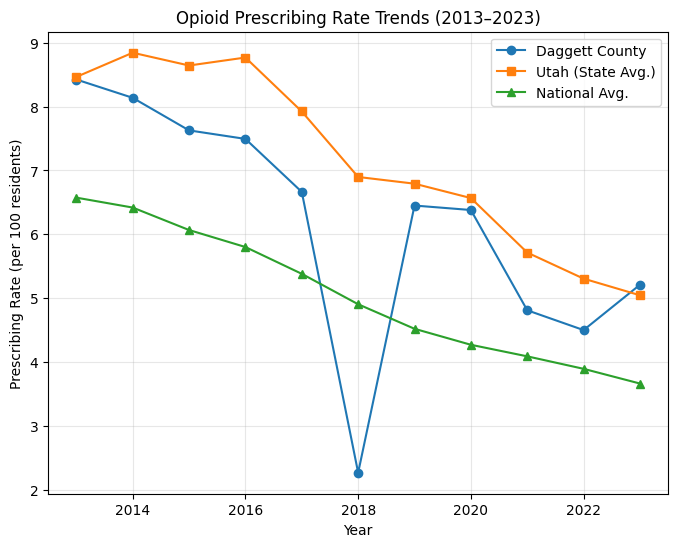

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your main panel dataset
panel = pd.read_csv("../data/results/panel_with_all_scenarios.csv")

# Focus on columns you need
cols = ["year", "state", "county", "opioid_prscrbng_rate", "opioid_cost_per_capita"]
panel = panel[cols]

# Compute mean prescribing rate by year for each level
daggett_trend = (
    panel[(panel["state"] == "Utah") & (panel["county"] == "Daggett")]
    .groupby("year")[["opioid_prscrbng_rate", "opioid_cost_per_capita"]]
    .mean()
    .reset_index()
)
utah_trend = (
    panel[panel["state"] == "Utah"]
    .groupby("year")[["opioid_prscrbng_rate", "opioid_cost_per_capita"]]
    .mean()
    .reset_index()
)
national_trend = (
    panel.groupby("year")[["opioid_prscrbng_rate", "opioid_cost_per_capita"]]
    .mean()
    .reset_index()
)

# Plot prescribing rate comparison
plt.figure(figsize=(8,6))
plt.plot(daggett_trend["year"], daggett_trend["opioid_prscrbng_rate"], 
         marker='o', label="Daggett County")
plt.plot(utah_trend["year"], utah_trend["opioid_prscrbng_rate"], 
         marker='s', label="Utah (State Avg.)")
plt.plot(national_trend["year"], national_trend["opioid_prscrbng_rate"], 
         marker='^', label="National Avg.")
plt.title("Opioid Prescribing Rate Trends (2013–2023)")
plt.xlabel("Year")
plt.ylabel("Prescribing Rate (per 100 residents)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
